# Neural Ordinary Differential Equation

This notebook is meant to play and experiment with code in preperation for a talk I plan to give.

Original code is from this blogpost:
https://sebastiancallh.github.io/post/neural-ode-weather-forecast/


In [1]:
using DiffEqFlux

function neural_ode(t, data_dim; saveat = t)
    f = FastChain(FastDense(data_dim, 64, swish),
          FastDense(64, 32, swish),
          FastDense(32, data_dim))

    node = NeuralODE(f, (minimum(t), maximum(t)), Tsit5(),
             saveat = saveat, abstol = 1e-9,
             reltol = 1e-9)
end

neural_ode (generic function with 1 method)

In [2]:
using DataFrames, CSV

In [3]:
using Plots
using LaTeXStrings # This is amazing :D

In [4]:
delhi_train = CSV.read("data/DailyDelhiClimateTrain.csv")
delhi_test = CSV.read("data/DailyDelhiClimateTest.csv")
delhi = vcat(delhi_train, delhi_test)

,date,meantemp,humidity,wind_speed,meanpressure
,Date…,Float64,Float64,Float64,Float64
1,2013-01-01,10.0,84.5,0.0,1015.67
2,2013-01-02,7.4,92.0,2.98,1017.8
3,2013-01-03,7.16667,87.0,4.63333,1018.67
4,2013-01-04,8.66667,71.3333,1.23333,1017.17
5,2013-01-05,6.0,86.8333,3.7,1016.5
6,2013-01-06,7.0,82.8,1.48,1018.0
7,2013-01-07,7.0,78.6,6.3,1020.0
8,2013-01-08,8.85714,63.7143,7.14286,1018.71
9,2013-01-09,14.0,51.25,12.5,1017.0


In [5]:
using Statistics
using Base.Iterators: take, cycle
using Dates

In [6]:
delhi[:,:year] = Float64.(year.(delhi[:,:date]))
delhi[:,:month] = Float64.(month.(delhi[:,:date]))
df_mean = by(delhi, [:year, :month],
         :meantemp => mean,
         :humidity => mean,
         :wind_speed => mean,
         :meanpressure => mean)

rename!(df_mean, [:year, :month, :meantemp,
          :humidity, :wind_speed, :meanpressure])

df_mean[!,:date] .= df_mean[:,:year] .+ df_mean[:,:month] ./ 12;

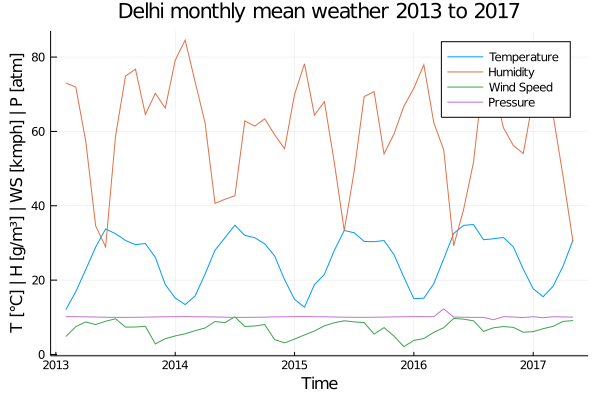

In [7]:
plot(df_mean["date"], df_mean["meantemp"], label="Temperature")
plot!(df_mean["date"], df_mean["humidity"], label="Humidity")
plot!(df_mean["date"], df_mean["wind_speed"], label="Wind Speed")
plot!(df_mean["date"], df_mean["meanpressure"] / 100, label="Pressure", xaxis="Time",
    title="Delhi monthly mean weather 2013 to 2017",
    yaxis="T [°C] | H [g/m³] | WS [kmph] | P [atm]")

In [ ]:
png("delhi_weather.png")

In [8]:
t = df_mean[:, :date] |>
    t -> t .- minimum(t) |>
    t -> reshape(t, 1, :)

u = df_mean[:, ["meantemp", "humidity", "wind_speed", "meanpressure"]] |>
    u -> Matrix(u)' |>
    u -> (u .- mean(u, dims = 2)) ./ std(u, dims = 2)

T = 20
train_dates = df_mean[1:T, :date]
test_dates = df_mean[T+1:end, :date]
train_t, test_t = t[1:T], t[T:end]
train_u, test_u = u[:,1:T], u[:,T:end];

In [11]:
using OrdinaryDiffEq, Flux, Random

function train_one_round(node, θ, u, opt, maxiters,
                 u0 = u[:, 1]; kwargs...)
    predict(θ) = Array(node(u0, θ))
    loss(θ) = begin
        û = predict(θ)
        Flux.mse(û, u)
    end

    θ = θ == nothing ? node.p : θ
    res = DiffEqFlux.sciml_train(
        loss, θ, opt,
        maxiters = maxiters;
        kwargs...
    )
    return res.minimizer
end


function train(θ = nothing, maxiters = 150, lr = 1e-2)
    log_results(θs, losses) =
        (θ, loss) -> begin
            push!(θs, copy(θ))
            push!(losses, loss)
            false
        end

    θs, losses = [], []
    num_obs = 4:4:length(train_t)
    for k in num_obs
        node = neural_ode(train_t[1:k], size(u, 1))
        θ = train_one_round(
            node, θ, train_u[:, 1:k],
            ADAMW(lr), maxiters;
            cb = log_results(θs, losses)
        )
    end
    θs, losses, θ
end

train (generic function with 4 methods)

In [12]:
Random.seed!(1)
θs, losses, θ = train();

loss: 0.000253: 100%|█████████████████████████████████████████| Time: 0:00:03
loss: 0.0173: 100%|█████████████████████████████████████████| Time: 0:00:04
loss: 0.0565: 100%|█████████████████████████████████████████| Time: 0:00:06
loss: 0.0518: 100%|█████████████████████████████████████████| Time: 0:00:08
loss: 0.0557: 100%|█████████████████████████████████████████| Time: 0:00:10


## Play with results

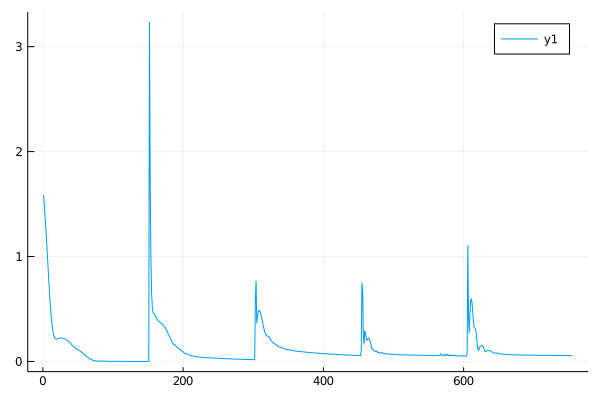

In [13]:
plot(losses)

In [14]:
node = neural_ode(train_t[1:20], size(u, 1))
u0 = u[:, 1]
predict(θ) = Array(node(u0, θ))

predict (generic function with 1 method)

In [15]:
Flux.mse(predict(node.p), train_u[:, 1:20]), Flux.mse(predict(θ), train_u[:, 1:20])

(2.3003196524048706, 0.05563015926771153)

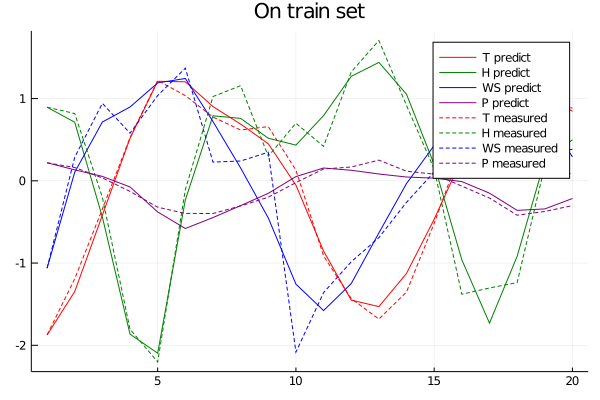

In [16]:
u0 = train_u[:, 1]
predict(θ) = Array(node(u0, θ))

û = predict(θ)
plot(û[:1, :], color="red", label="T predict")
plot!(û[:2, :], color="green",label="H predict")
plot!(û[:3, :], color="blue", label="WS predict")
plot!(û[:4, :], color="purple", label="P predict")

plot!(train_u[:1, 1:20], color="red", ls=:dash, label="T measured")
plot!(train_u[:2, 1:20], color="green", ls=:dash, label="H measured")
plot!(train_u[:3, 1:20], color="blue", ls=:dash, label="WS measured")
plot!(train_u[:4, 1:20], color="purple", ls=:dash, label="P measured",
    title="On train set")

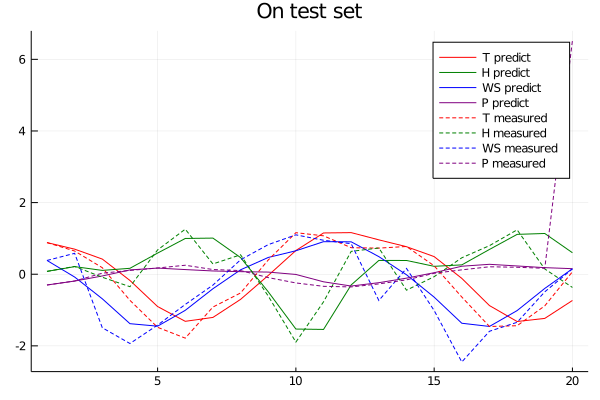

In [17]:
u0 = test_u[:, 1]
predict(θ) = Array(node(u0, θ))

û = predict(θ)
plot(û[:1, :], color="red", label="T predict")
plot!(û[:2, :], color="green",label="H predict")
plot!(û[:3, :], color="blue", label="WS predict")
plot!(û[:4, :], color="purple", label="P predict")

plot!(test_u[:1, 1:20], color="red", ls=:dash, label="T measured")
plot!(test_u[:2, 1:20], color="green", ls=:dash, label="H measured")
plot!(test_u[:3, 1:20], color="blue", ls=:dash, label="WS measured")
plot!(test_u[:4, 1:20], color="purple", ls=:dash, label="P measured",
    title="On test set")

In [23]:
node = neural_ode(test_t[:], size(u, 1))
u0 = test_u[:, 1]
predict(θ) = Array(node(u0, θ))

predict (generic function with 1 method)

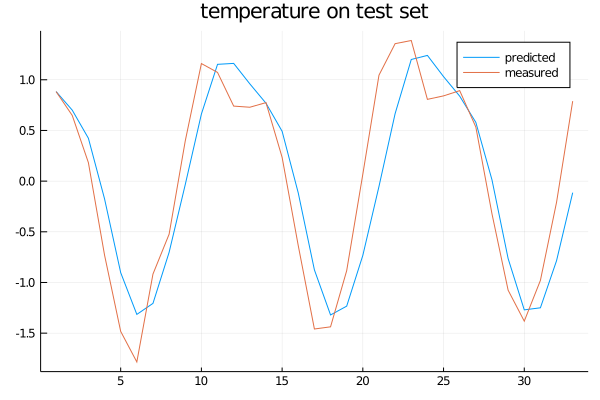

In [31]:
û = predict(θ)
plot(û[:1, :], label="predicted")
plot!(test_u[:1, :], label="measured", title="temperature on test set")

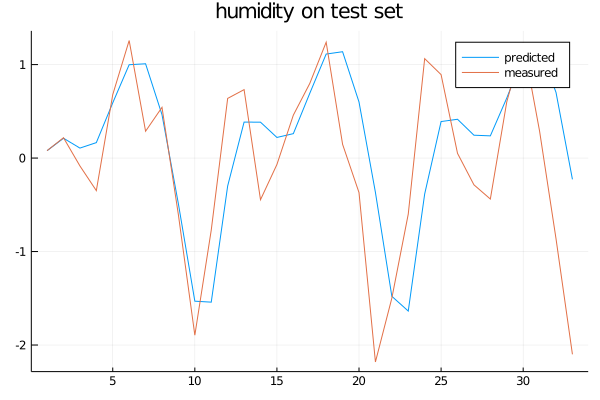

In [30]:
plot(û[:2, :], label="predicted")
plot!(test_u[:2, :], label="measured", title="humidity on test set")

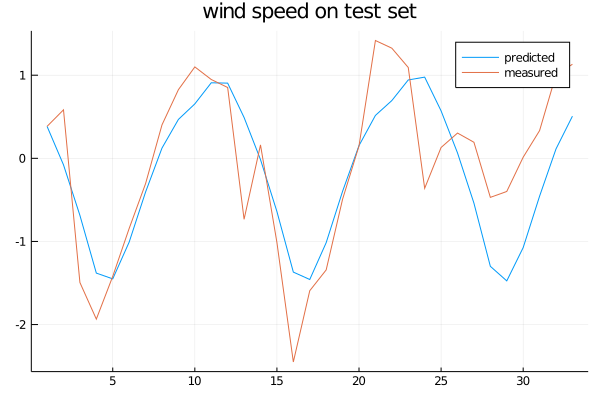

In [32]:
plot(û[:3, :], label="predicted")
plot!(test_u[:3, :], label="measured", title="wind speed on test set")

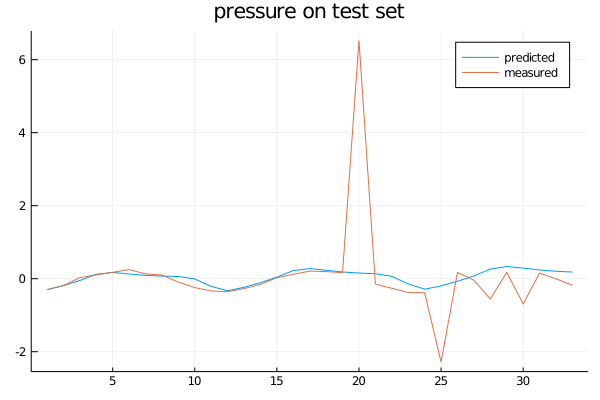

In [33]:
plot(û[:4, :], label="predicted")
plot!(test_u[:4, :], label="measured", title="pressure on test set")

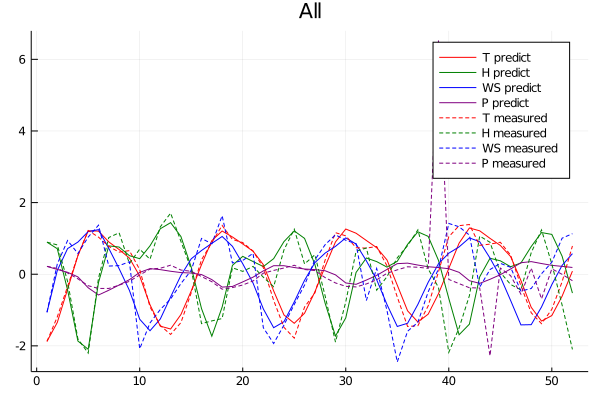

In [56]:
node = neural_ode(t[1:end], size(u, 1))
u0 = train_u[:, 1]
predict(θ) = Array(node(u0, θ))

û = predict(θ)
plot(û[:1, :], color="red", label="T predict")
plot!(û[:2, :], color="green",label="H predict")
plot!(û[:3, :], color="blue", label="WS predict")
plot!(û[:4, :], color="purple", label="P predict")

plot!(u[:1, :], color="red", ls=:dash, label="T measured")
plot!(u[:2, :], color="green", ls=:dash, label="H measured")
plot!(u[:3, :], color="blue", ls=:dash, label="WS measured")
plot!(u[:4, :], color="purple", ls=:dash, label="P measured",
    title="On all")

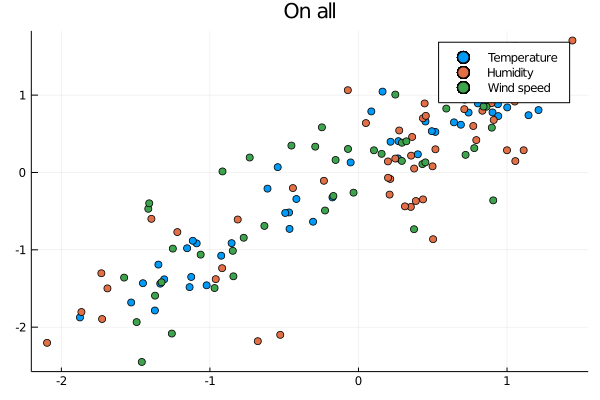

In [62]:
plot(û[:1, :], u[:1, :], seriestype = :scatter, label="Temperature")
plot!(û[:2, :], u[:2, :], seriestype = :scatter, label="Humidity")
plot!(û[:3, :], u[:3, :], seriestype = :scatter, label="Wind speed", title = "On all")

## Simple ODE

Example of a simple ODE,

\begin{align*}
\frac{\partial u}{\partial t} &= 2u(t)\\
u(0) &= \frac{1}{2}
\end{align*}

We'll use the euler method because that's what we used in the talk to illustrate the forward pass math.

In [2]:
using DifferentialEquations
using OrdinaryDiffEq

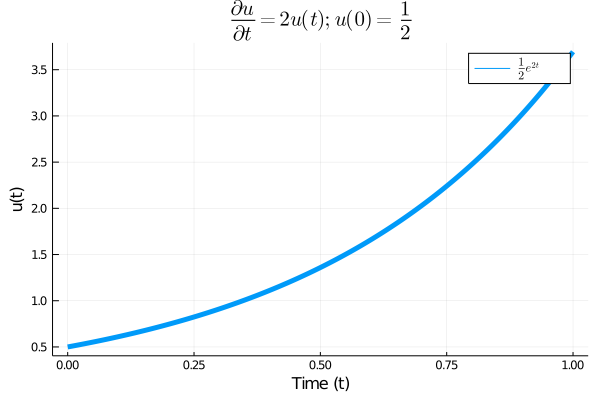

In [120]:
f(u,p,t) = 2*u
u0 = 1/2
tspan = (0.0,1.0)

prob = ODEProblem(f,u0,tspan)
sol = solve(prob, Euler(), dt=0.001)

plot(sol.t, t->0.5*exp(2t),lw=5, label=L"\frac{1}{2}e^{2t}", yaxis="u(t)", xaxis="Time (t)",
    title=L"\frac{\partial u}{\partial t} = 2u(t) ; u(0) = \frac{1}{2}")

In [121]:
# Save the plot as png
png("ode1.png")

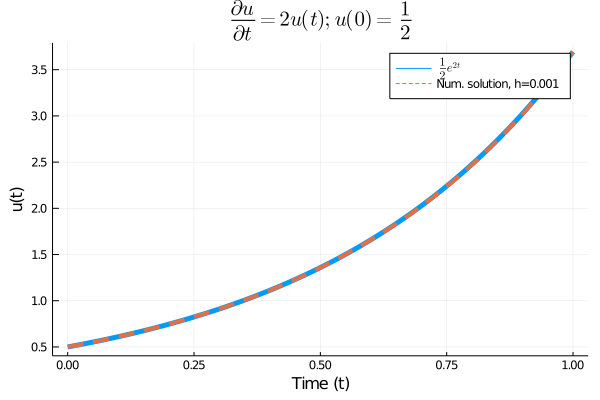

In [154]:
plot(sol.t, t->0.5*exp(2t),lw=5, label=L"\frac{1}{2}e^{2t}", yaxis="u(t)", xaxis="Time (t)",
    title=L"\frac{\partial u}{\partial t} = 2u(t) ; u(0) = \frac{1}{2}")

plot!(sol.t, sol.u, linewidth=4, ls=:dash, label="Num. solution, h=0.001", xaxis="Time (t)")

In [128]:
png("ode2.png")

 ### Additional stuff
 
 Here's the training code again in a slide friendly format without the train function.

In [ ]:
using OrdinaryDiffEq, Flux

function train_one_round(node, θ, u, opt, maxiters,
                 u0 = data[:, 1])
    predict(θ) = Array(node(u0, θ))
    loss(θ) = begin
        û = predict(θ)
        Flux.mse(û, u)
    end

    θ = θ == nothing ? node.p : θ
    res = DiffEqFlux.sciml_train(
        loss, θ, opt,
        maxiters = maxiters
    )
    return res.minimizer
end

node = neural_ode(train_t, 4)

θ = train_one_round(node, θ, train_u, ADAMW(1e-2), 150)